In [1]:
from __future__ import print_function

In [2]:
import librosa
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [3]:
y, sr = librosa.load('audio/Karissa_Hobbs_-_09_-_Lets_Go_Fishin.mp3')

In [4]:
C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3, real=False))

In [5]:
# First, let's plot the original chroma, with and without frequency over-sampling
chroma_orig = librosa.feature.chroma_cqt(y=y, sr=sr)

In [6]:
# For display purposes, let's zoom in on a 15-second chunk from the middle of the song
idx = [slice(None), slice(*list(librosa.time_to_frames([45, 60])))]

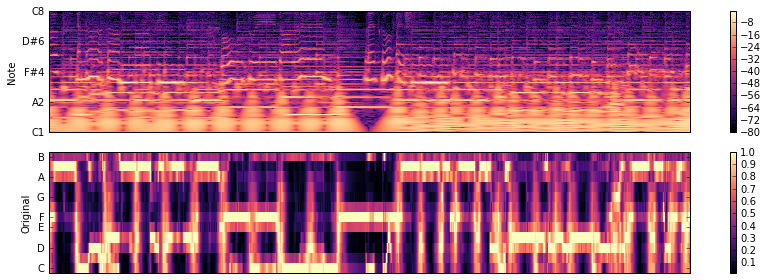

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.logamplitude(C**2, ref_power=np.max)[idx],
                         y_axis='cqt_note', bins_per_octave=12*3)
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Original')
plt.tight_layout()

In [8]:
# We can correct for minor tuning deviations by using 3 CQT bins per semi-tone, instead of 1
chroma_os = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=12*3)

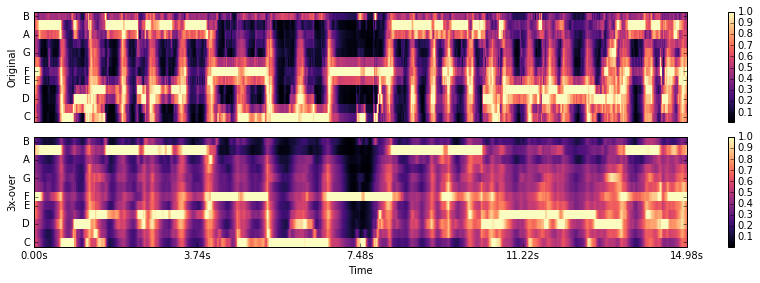

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(2,1,1)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Original')


plt.subplot(2,1,2)
librosa.display.specshow(chroma_os[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('3x-over')
plt.tight_layout()

In [20]:
# That cleaned up some rough edges, but we can do better by isolating the harmonic component
y_harm = librosa.effects.harmonic(y=y, margin=8)
chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, bins_per_octave=12*3)

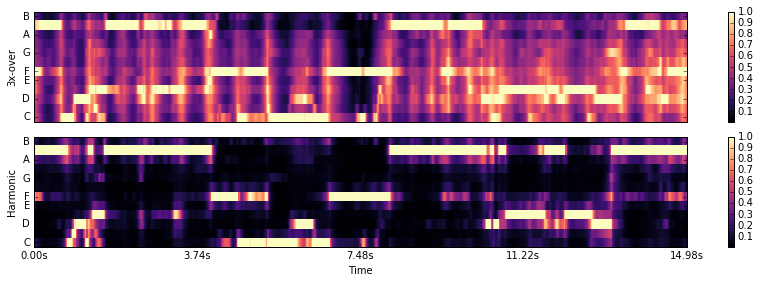

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(2,1,1)
librosa.display.specshow(chroma_os[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('3x-over')

plt.subplot(2,1,2)
librosa.display.specshow(chroma_os_harm[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Harmonic')
plt.tight_layout()

In [22]:
# There's still some noise in there though.  We can clean it up using non-local filtering
chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm, aggregate=np.median, metric='cosine'))

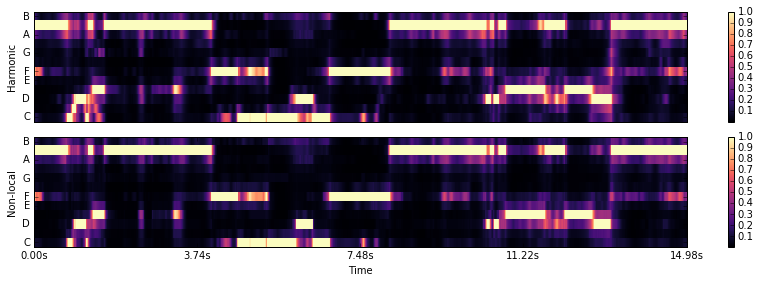

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(2,1,1)
librosa.display.specshow(chroma_os_harm[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Harmonic')

plt.subplot(2,1,2)
librosa.display.specshow(chroma_filter[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Non-local')
plt.tight_layout()

In [24]:
# And finally a horizontal median filter to smooth out remaining transients
chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))

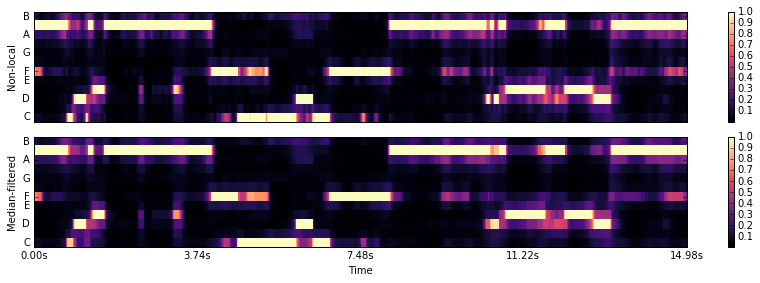

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(2,1,1)
librosa.display.specshow(chroma_filter[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Non-local')

plt.subplot(2,1,2)
librosa.display.specshow(chroma_smooth[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Median-filtered')
plt.tight_layout()

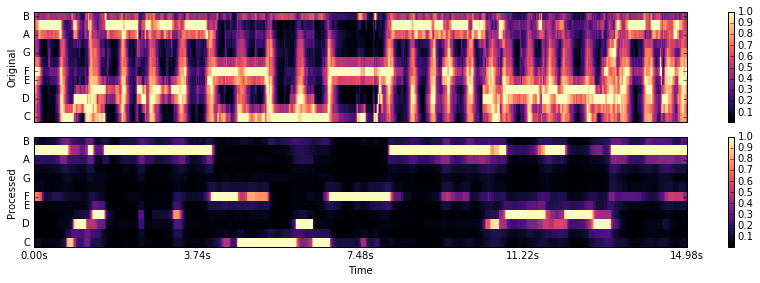

In [26]:
# A final comparison between the original chromagram and our processed one
plt.figure(figsize=(12, 4))
plt.subplot(2,1,1)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.ylabel('Original')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(chroma_smooth[idx], y_axis='chroma', x_axis='time')
plt.ylabel('Processed')
plt.colorbar()
plt.tight_layout()

In [27]:
# Now let's plot some recurrence matrices using each variation

R_orig = librosa.segment.recurrence_matrix(chroma_orig, mode='affinity', sparse=True, metric='cosine', sym=True)
R_os = librosa.segment.recurrence_matrix(chroma_os, mode='affinity',  sparse=True, metric='cosine', sym=True)
R_os_harm = librosa.segment.recurrence_matrix(chroma_os_harm, mode='affinity',  sparse=True, metric='cosine', sym=True)
R_filter = librosa.segment.recurrence_matrix(chroma_filter, mode='affinity',  sparse=True, metric='cosine', sym=True)
R_smooth = librosa.segment.recurrence_matrix(chroma_smooth, mode='affinity',  sparse=True, metric='cosine', sym=True)

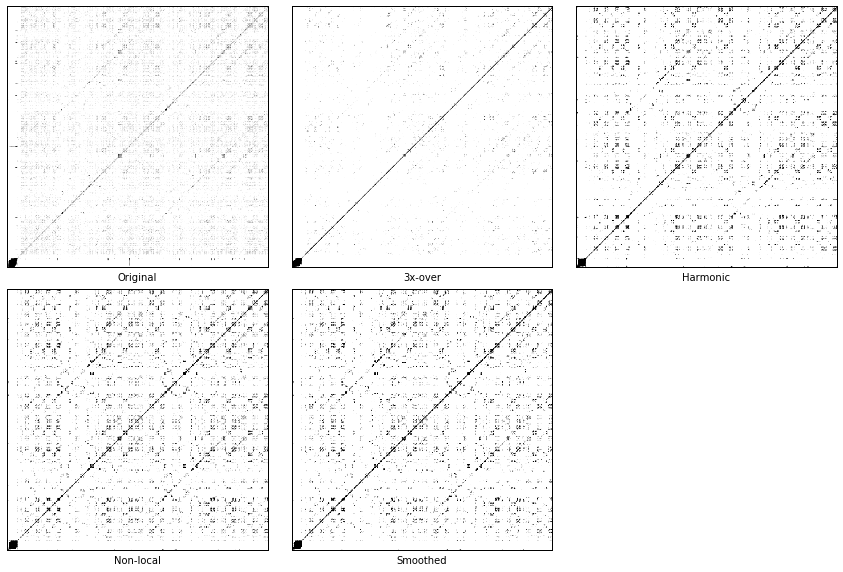

In [29]:
plt.figure(figsize=(12, 8))

for i, (_r, _t) in enumerate([(R_orig, 'Original'), 
                              (R_os, '3x-over'), 
                              (R_os_harm, 'Harmonic'), 
                              (R_filter, 'Non-local'),
                              (R_smooth, 'Smoothed')], 1):
    plt.subplot(2, 3, i)
    plt.spy(_r[:, ::-1], precision=0.75, markersize=1e-2)
    plt.xlabel(_t)
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()